# Wind Climatology Maps

In [3]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import xarray as xr
import cmocean
from salishsea_tools import viz_tools
from salishsea_tools import geo_tools
from salishsea_tools import grid_tools
from salishsea_tools import utilities
%matplotlib inline
speed_cmap = cmocean.cm.speed

In [4]:
GEM = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1")  # HDPRC latlon
nemo_mask =xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSn2DMeshMaskV17-02") # NEMO land mask
nemo_grid = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02") # NEMO lat lon
winddata = xr.open_dataset("https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaSurfaceAtmosphereFieldsV1") # Contains wind data

In [20]:
wind_u = winddata.u_wind.loc[winddata['time.year'].isin([2015, 2016, 2016, 2017, 2018])]
wind_v = winddata.v_wind.loc[winddata['time.year'].isin([2015, 2016, 2016, 2017, 2018])]

In [5]:
def build_GEM_mask(grid_GEM, grid_NEMO, mask_NEMO):


    # Preallocate
    ngrid_GEM = grid_GEM['gridX'].shape[0] * grid_GEM['gridY'].shape[0]
    mask_GEM = np.zeros(ngrid_GEM, dtype=int)

    # Evaluate each point on GEM grid
    bar = utilities.statusbar('Building GEM mask', width=90, maxval=ngrid_GEM)
    for index, coords in enumerate(bar(zip(
            grid_GEM['longitude'].values.reshape(ngrid_GEM) - 360,
            grid_GEM['latitude'].values.reshape(ngrid_GEM),
    ))):

        j, i = geo_tools.find_closest_model_point(
            coords[0], coords[1],
            grid_NEMO['longitude'], grid_NEMO['latitude'],
        )
        if j is np.nan or i is np.nan:
            mask_GEM[index] = 0
        else:
            mask_GEM[index] = mask_NEMO[j, i].values

    # Reshape
    mask_GEM = mask_GEM.reshape(grid_GEM['longitude'].shape)

    return mask_GEM

In [6]:
land_mask = build_GEM_mask(GEM, nemo_grid, nemo_mask.tmaskutil.isel(time=0))

Building GEM mask 100% (68096 of 68096) |##################################|Time:  0:07:00


In [7]:
def mask_data(data, land_mask = land_mask):
    masked_data = ma.masked_array(data, np.logical_not(land_mask))  # mask the data
    remove_zero_rows = masked_data[~(masked_data==np.nan).all(1)]   # remove rows with only zero entries
    transpose_rows = np.transpose(remove_zero_rows)                 # transpose the resulting array
    remove_zero_cols = np.transpose(transpose_rows[~(transpose_rows==np.nan).all(1)])  # remove the column with only zero entries
    return remove_zero_cols

## Computing all wind magnitudes

In [ ]:
## import data as dictionary

In [273]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbrs = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
# data sets by month
monthly_data = {}
bar = utilities.statusbar('loading', maxval=12)
for month, abbr in bar(zip(range(1,13) , abbrs)):
    monthly_data.update({abbr+'_data' :  xr.ufuncs.sqrt(wind_u.loc[wind_u['time.month'].isin([month])]**2 + wind_v.loc[wind_v['time.month'].isin([month])]**2)})

loading 100% (12 of 12) |#######################################|Time:  0:32:52


## Function Definition

In [298]:
names = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
abbr = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'july', 'aug', 'sept', 'oct' ,'nov' ,'dec']
operation_names = ['Mean', 'Standard Deviation', 'Maxima']
operations = ['mean', 'std', 'max']
thresholds = [5,10]


def produce_plots(names, abbr, operations, operation_names, thresholds, rows=4, cols=3, folder='test', colormap='Reds'):
    # listofString listofString listofString listofNumber Integer Integer String String
    # produce pdf plots of data by operation and as percentage of datasets that exceed threshold
    # datasets as dictionary
    # abbr must contain prefixes of dictionary keys {}_data
    
    
    # plot data with applied xarray operations
    for operation in np.arange(len(operations)):
        fig = plt.figure()
        fig.set_size_inches(8.27, 11.69)
        overall_min = False
        overall_max = 0
        
        for time_period in range(len(names)): # time_period is month index
            array = getattr(dictionary_data[abbr[time_period] + '_data'], operations[operation])(**{'axis': 0}).values # get data and apply operation
            locals()[abbr[time_period] + '_temp'] = mask_data(array) # mask array
            
            # find universal minimum and maximum values for colorbar normalisation
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])  
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max

        # produce subplots       
        for time_period in range(len(names)):
            ax = plt.subplot(rows,cols,time_period+1)
            plt.pcolormesh(locals()[abbr[time_period] + '_temp'], vmin = overall_min, vmax = overall_max, cmap = colormap)          
            viz_tools.set_aspect(ax)
            plt.title(names[time_period])
            plt.xlabel('X')
            plt.ylabel('Y')
        
        # adjust and save plots as .pdf
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.48)
        figtitle = '{} of wind speeds 2014-2018 (m/s)'.format(operation_names[operation])
        fig.suptitle(figtitle, fontsize  =  18)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([overall_min,overall_max])), cmap = 'Reds'), cax=cbar_ax)
        fname = '{}_winds.pdf'.format(operations[operation])
        plt.savefig(fname, bbox_inches = 'tight', dpi = 300)
    
    # plot data with threshold percentages
    for threshold in thresholds:
        fig = plt.figure()
        fig.set_size_inches(8.27, 11.69)
        overall_min = False
        overall_max = 0
        
        for time_period in np.arange(len(names)): # time_periods is month index
            
            # count over all grids instances of threshold being exceeded
            time_steps = dictionary_data[abbr[time_period] + '_data'].time.size
            percentdata = dictionary_data[abbr[time_period] + '_data'].values
            condlist = [percentdata > threshold, percentdata <= threshold] 
            choicelist = [1, 0]
            locals()[abbr[i] + '_temp'] = mask_data(np.sum(np.select(condlist, choicelist), axis = 0) / time_steps * 100)
            
            # universal minima and maxima for colorbar normalisation 
            time_period_min = np.amin(locals()[abbr[time_period] + '_temp'])
            time_period_max = np.amax(locals()[abbr[time_period] + '_temp'])
    
            if overall_min is False:
                overall_min = time_period_min
                overall_max = time_period_max
            if time_period_min < overall_min:
                overall_min = time_period_min
            if time_period_max > overall_max:
                overall_max = time_period_max
                
        # produce subplots       
        for time_period in range(len(names)):
            ax = plt.subplot(rows,cols,time_period+1)
            plt.pcolormesh(locals()[abbr[time_period] + '_temp'], vmin = overall_min, vmax = overall_max, cmap = colormap)          
            viz_tools.set_aspect(ax)
            plt.title(names[time_period])
            plt.xlabel('X')
            plt.ylabel('Y')

        # adjust and save plots as .pdf
        plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.48)
        figtitle = 'Percentage of wind speeds that exceeded {} m/s 2014-2018'.format(threshold)
        fig.suptitle(figtitle, fontsize  =  18)
        cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
        fig.colorbar(plt.pcolormesh(np.meshgrid(np.array([overall_min,overall_max])), cmap = 'Reds'), cax=cbar_ax)
        fname = '{}_percent_winds.pdf'.format(threshold)
        plt.savefig(fname, bbox_inches = 'tight', dpi = 300)
    

In [299]:
# export the distionary to a .csv file
import csv
 
w = csv.writer(open("monthly_data.csv", "w"))
for key, val in monthly_data.items():
    w.writerow([key, val])

In [300]:
# export the GEM mask to a csv file
np.savetxt("land_mask.csv", land_mask, delimiter=",")

## Monthly Wind Data

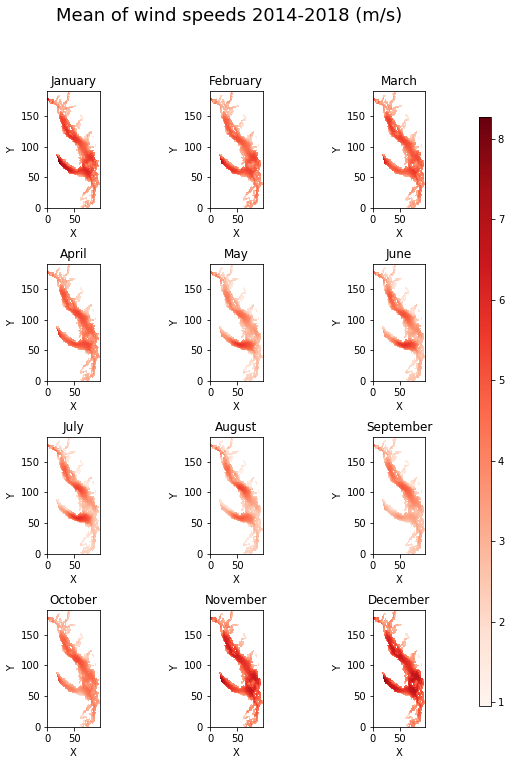

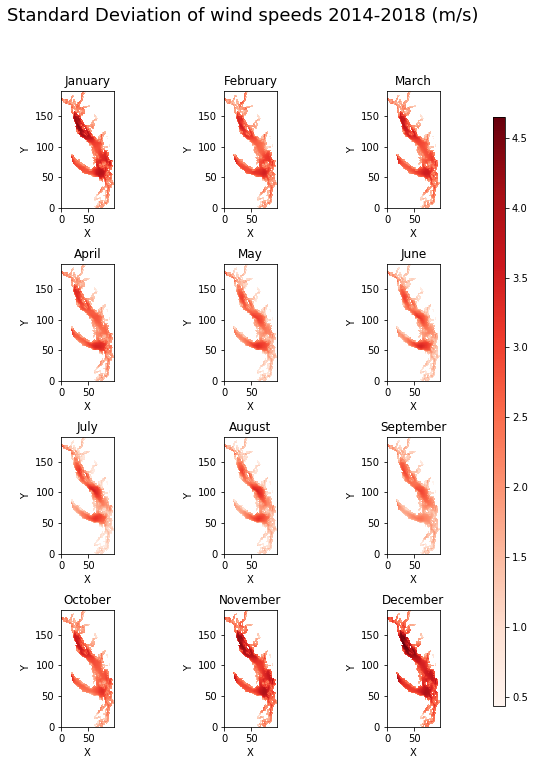

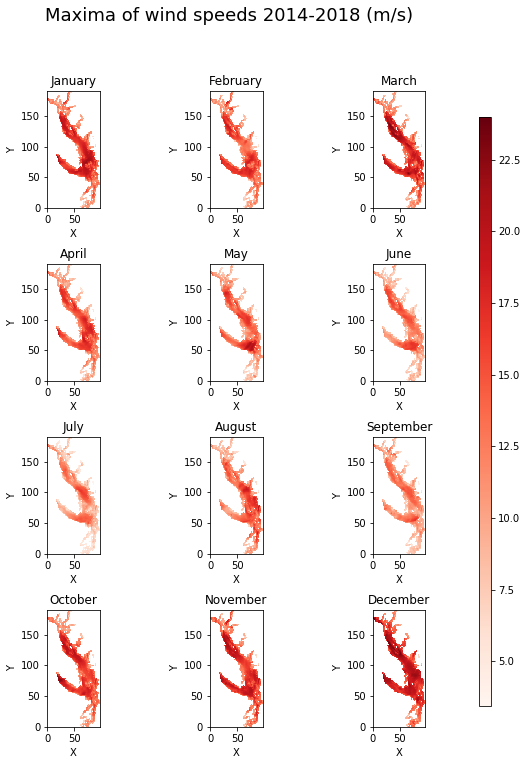

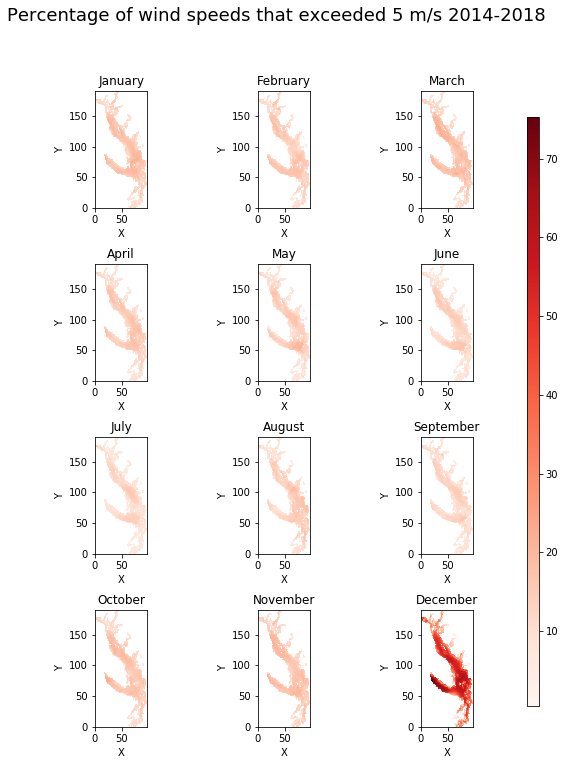

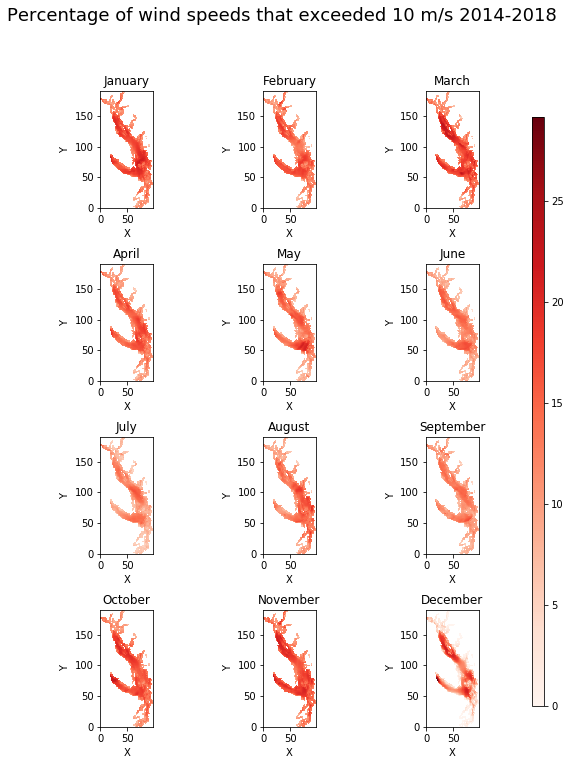

In [301]:
dictionary_data = monthly_data.copy()
produce_plots(names, abbr, operations, operation_names, thresholds, rows=4, cols=3, folder='test', colormap='Reds')

In [302]:
# Todo: wind analysis by season and wind analysis by year